In [29]:
import jetnet
import numpy as np
import matplotlib.pyplot as plt
import gen_metrics
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [41]:
import os

plot_dir = "../plots/jet_plots/Oct11"
_ = os.system(f"mkdir -p {plot_dir}")

data_dir = "../saved_data/"


In [7]:
jetnet.datasets.JetNet.all_particle_features


['etarel', 'phirel', 'ptrel', 'mask']

In [4]:
truth_jets_pf, _ = jetnet.datasets.JetNet.getData(
    "g",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[1.0, 0, 0],
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)


In [72]:
# efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])
# np.save("efps", efps)


In [44]:
efps_true = np.load(f"{data_dir}/efps_true.npy")
pnet_activations_true = np.load(f"{data_dir}/pnet_activations_true.npy")


In [9]:
from typing import OrderedDict
from coffea.lookup_tools.dense_lookup import dense_lookup

mass = jetnet.utils.jet_features(truth_jets_pf[:, :, :3])["mass"]

np.random.seed(4)

bins = np.linspace(0, np.max(mass), 26)
true_mass_hist = np.histogram(mass, bins)[0]

smeared_hist = np.histogram(mass * np.random.normal(1, 0.25, size=mass.shape), bins)[0]
shifted_hist = np.histogram(mass * np.random.normal(1.1, 0.05, size=mass.shape), bins)[0]

smeared_lookup = dense_lookup(smeared_hist / true_mass_hist, bins)
shifted_lookup = dense_lookup(shifted_hist / true_mass_hist, bins)

smeared_weights = smeared_lookup(mass)
smeared_weights /= np.sum(smeared_weights)

shifted_weights = shifted_lookup(mass)
shifted_weights /= np.sum(shifted_weights)

tailcut_weights = (mass < 0.17).astype(float)
tailcut_weights /= np.sum(tailcut_weights)

dists = OrderedDict(
    [
        ("truth", (np.ones(truth_jets_pf.shape[0]) / truth_jets_pf.shape[0], "Truth")),
        ("smeared", (smeared_weights, "Smeared")),
        ("shifted", (shifted_weights, "Shifted")),
        ("tailcut", (tailcut_weights, "Removing Tail")),
    ]
)


In [24]:
np.random.seed(4)

pf_dists = OrderedDict()

pf_dists["all_smeared"] = (
    truth_jets_pf * np.random.normal(1, 0.25, size=truth_jets_pf.shape),
    "Particle Features Smeared",
)
pf_dists["eta_smeared"] = (
    np.concatenate(
        (
            truth_jets_pf[..., 0:1] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 0:1].shape),
            truth_jets_pf[..., 1:],
        ),
        axis=-1,
    ),
    r"Particle $\eta^{rel}$ Smeared",
)
pf_dists["pt_smeared"] = (
    np.concatenate(
        (
            truth_jets_pf[..., :2],
            truth_jets_pf[..., 2:3] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 2:3].shape),
        ),
        axis=-1,
    ),
    r"Particle $p_T^{rel}$ Smeared",
)
pf_dists["pt_shifted"] = (
    np.concatenate(
        (
            truth_jets_pf[..., :2],
            truth_jets_pf[..., 2:3]
            * np.random.normal(0.9, 0.1, size=truth_jets_pf[..., 2:3].shape),
        ),
        axis=-1,
    ),
    r"Particle $p_T^{rel}$ Shifted",
)


masses = {key: jetnet.utils.jet_features(jets)["mass"] for key, (jets, _) in pf_dists.items()}


In [31]:
# with open("pf_dists.pkl", "wb") as f:
#     pickle.dump(pf_dists, f)

In [28]:
efps = {
    key: jetnet.utils.efps(jets, efpset_args=[("d<=", 4)]) for key, (jets, _) in pf_dists.items()
}


In [30]:
# with open("efps_dict.pkl", "wb") as f:
#     pickle.dump(efps, f)

In [43]:
# with open(f"{data_dir}/pf_dists.pkl", 'rb') as f:
#     pf_dists = pickle.load(f)

# with open(f"{data_dir}/efps_dict.pkl", 'rb') as f:
#     efps = pickle.load(f)

pnet_activations = {}

for key in pf_dists:
    pnet_activations[key] = np.load(f"{data_dir}/pnet_activations_{key}.npy")


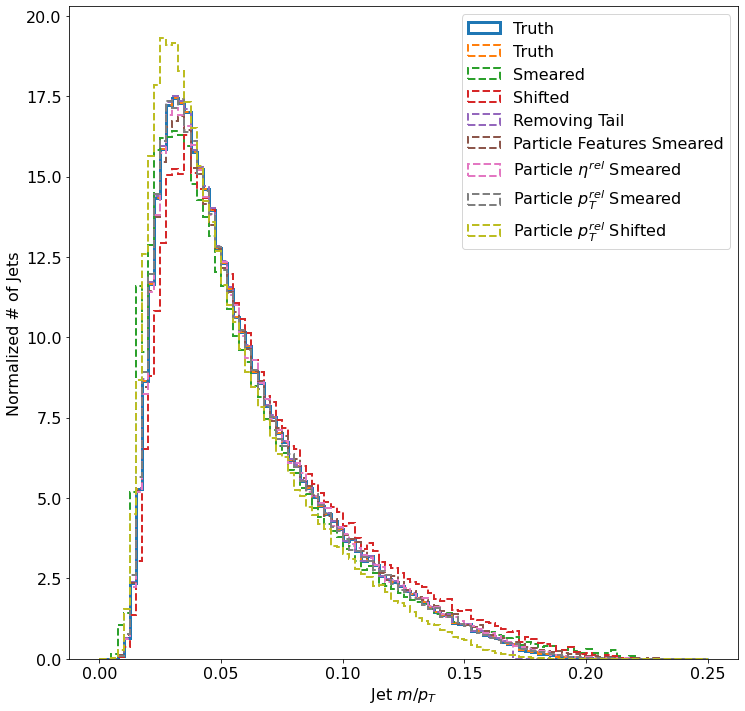

In [26]:
plt.figure(figsize=(12, 12))

bins = np.linspace(0, 0.25, 101)

_ = plt.hist(mass, bins, histtype="step", label="Truth", linewidth=3, density=True)
for weights, label in dists.values():
    _ = plt.hist(
        mass,
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        masses[key],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists.pdf", bbox_inches="tight")


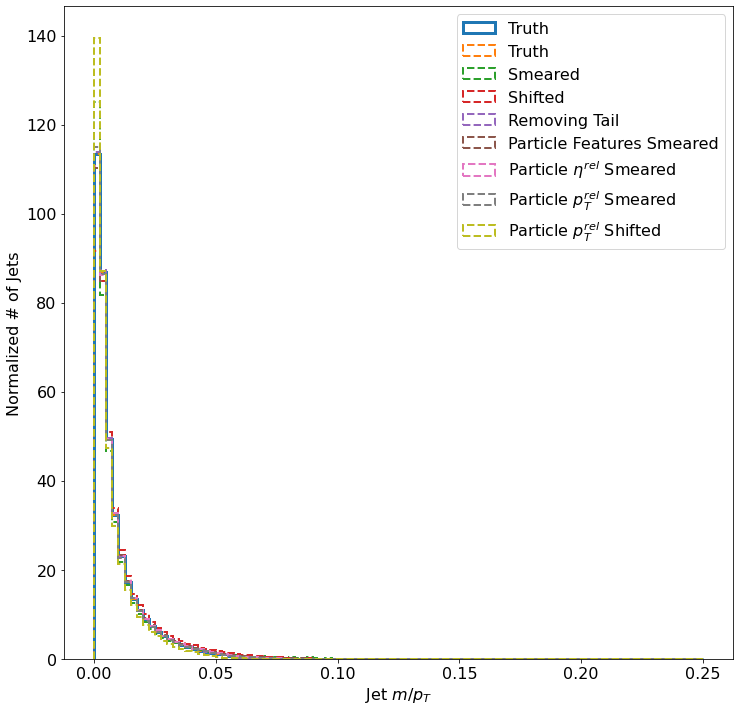

In [59]:
plt.figure(figsize=(12, 12))

# bins = np.linspace(0, 0.04, 101)
bins = np.linspace(0, 0.25, 101)
efp_index = 2

_ = plt.hist(efps_true[:, efp_index], bins, histtype="step", label="Truth", linewidth=3, density=True)
for weights, label in dists.values():
    _ = plt.hist(
        efps_true[:, efp_index],
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        efps[key][:, efp_index],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists_efp.pdf", bbox_inches="tight")


In [48]:
num_samples = 50_000
sample_efps = OrderedDict()
sample_acts = OrderedDict()

np.random.seed(4)
true_inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
true_efps = efps_true[true_inds]
true_acts = pnet_activations_true[true_inds]

for key, (weights, _) in dists.items():
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples, p=weights)
    sample_efps[key] = efps_true[inds]
    sample_acts[key] = pnet_activations_true[inds]

for key in pf_dists:
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
    sample_efps[key] = efps[key][inds]
    sample_acts[key] = pnet_activations[key][inds]


In [68]:
num_batches = 5

batch_sizes = {
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000],
    "fgd": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 25000],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000],
}

metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {}, "Wasserstein Distance")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        (
            "mmdup4",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 4},
                "MMD Poly Deg=4 Quadratic Unbiased Est.",
            ),
        ),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
    ]
)


In [69]:
if "measurements_efps" not in locals():
    measurements_efps = OrderedDict()

for dkey in sample_efps:
    print(dkey)
    if dkey not in measurements_efps:
        measurements_efps[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements_efps[dkey] and not (mkey == "pr" or mkey == "fgd"): #
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_efps,
                sample_efps[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args
            )
            ms.append(mean_std)
            ts.append(timing)
        measurements_efps[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


pr: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


smeared


pr: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


shifted


pr: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


tailcut


pr: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


all_smeared


pr: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


eta_smeared


pr: 100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


pt_smeared


pr: 100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


pt_shifted


pr: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


In [73]:
if "measurements_acts" not in locals():
    measurements_acts = OrderedDict()

for dkey in sample_acts:
    print(dkey)
    if dkey not in measurements_acts:
        measurements_acts[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if (
            mkey in measurements_acts[dkey]
        ):  # and not (mkey == "mmdup4"):  # not mkey.startswith("mmdu"): #
            continue

        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_acts,
                sample_acts[dkey],
                num_batches,
                batch_size,
                metric,
                timing=True,
                **metric_args,
                normalise=False
            )
            ms.append(mean_std)
            ts.append(timing)
        measurements_acts[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


pr: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


smeared


pr: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


shifted


pr: 100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


tailcut


pr: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


all_smeared


pr: 100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


eta_smeared


pr: 100%|██████████| 11/11 [00:20<00:00,  1.83s/it]


pt_smeared


pr: 100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


pt_shifted


pr: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


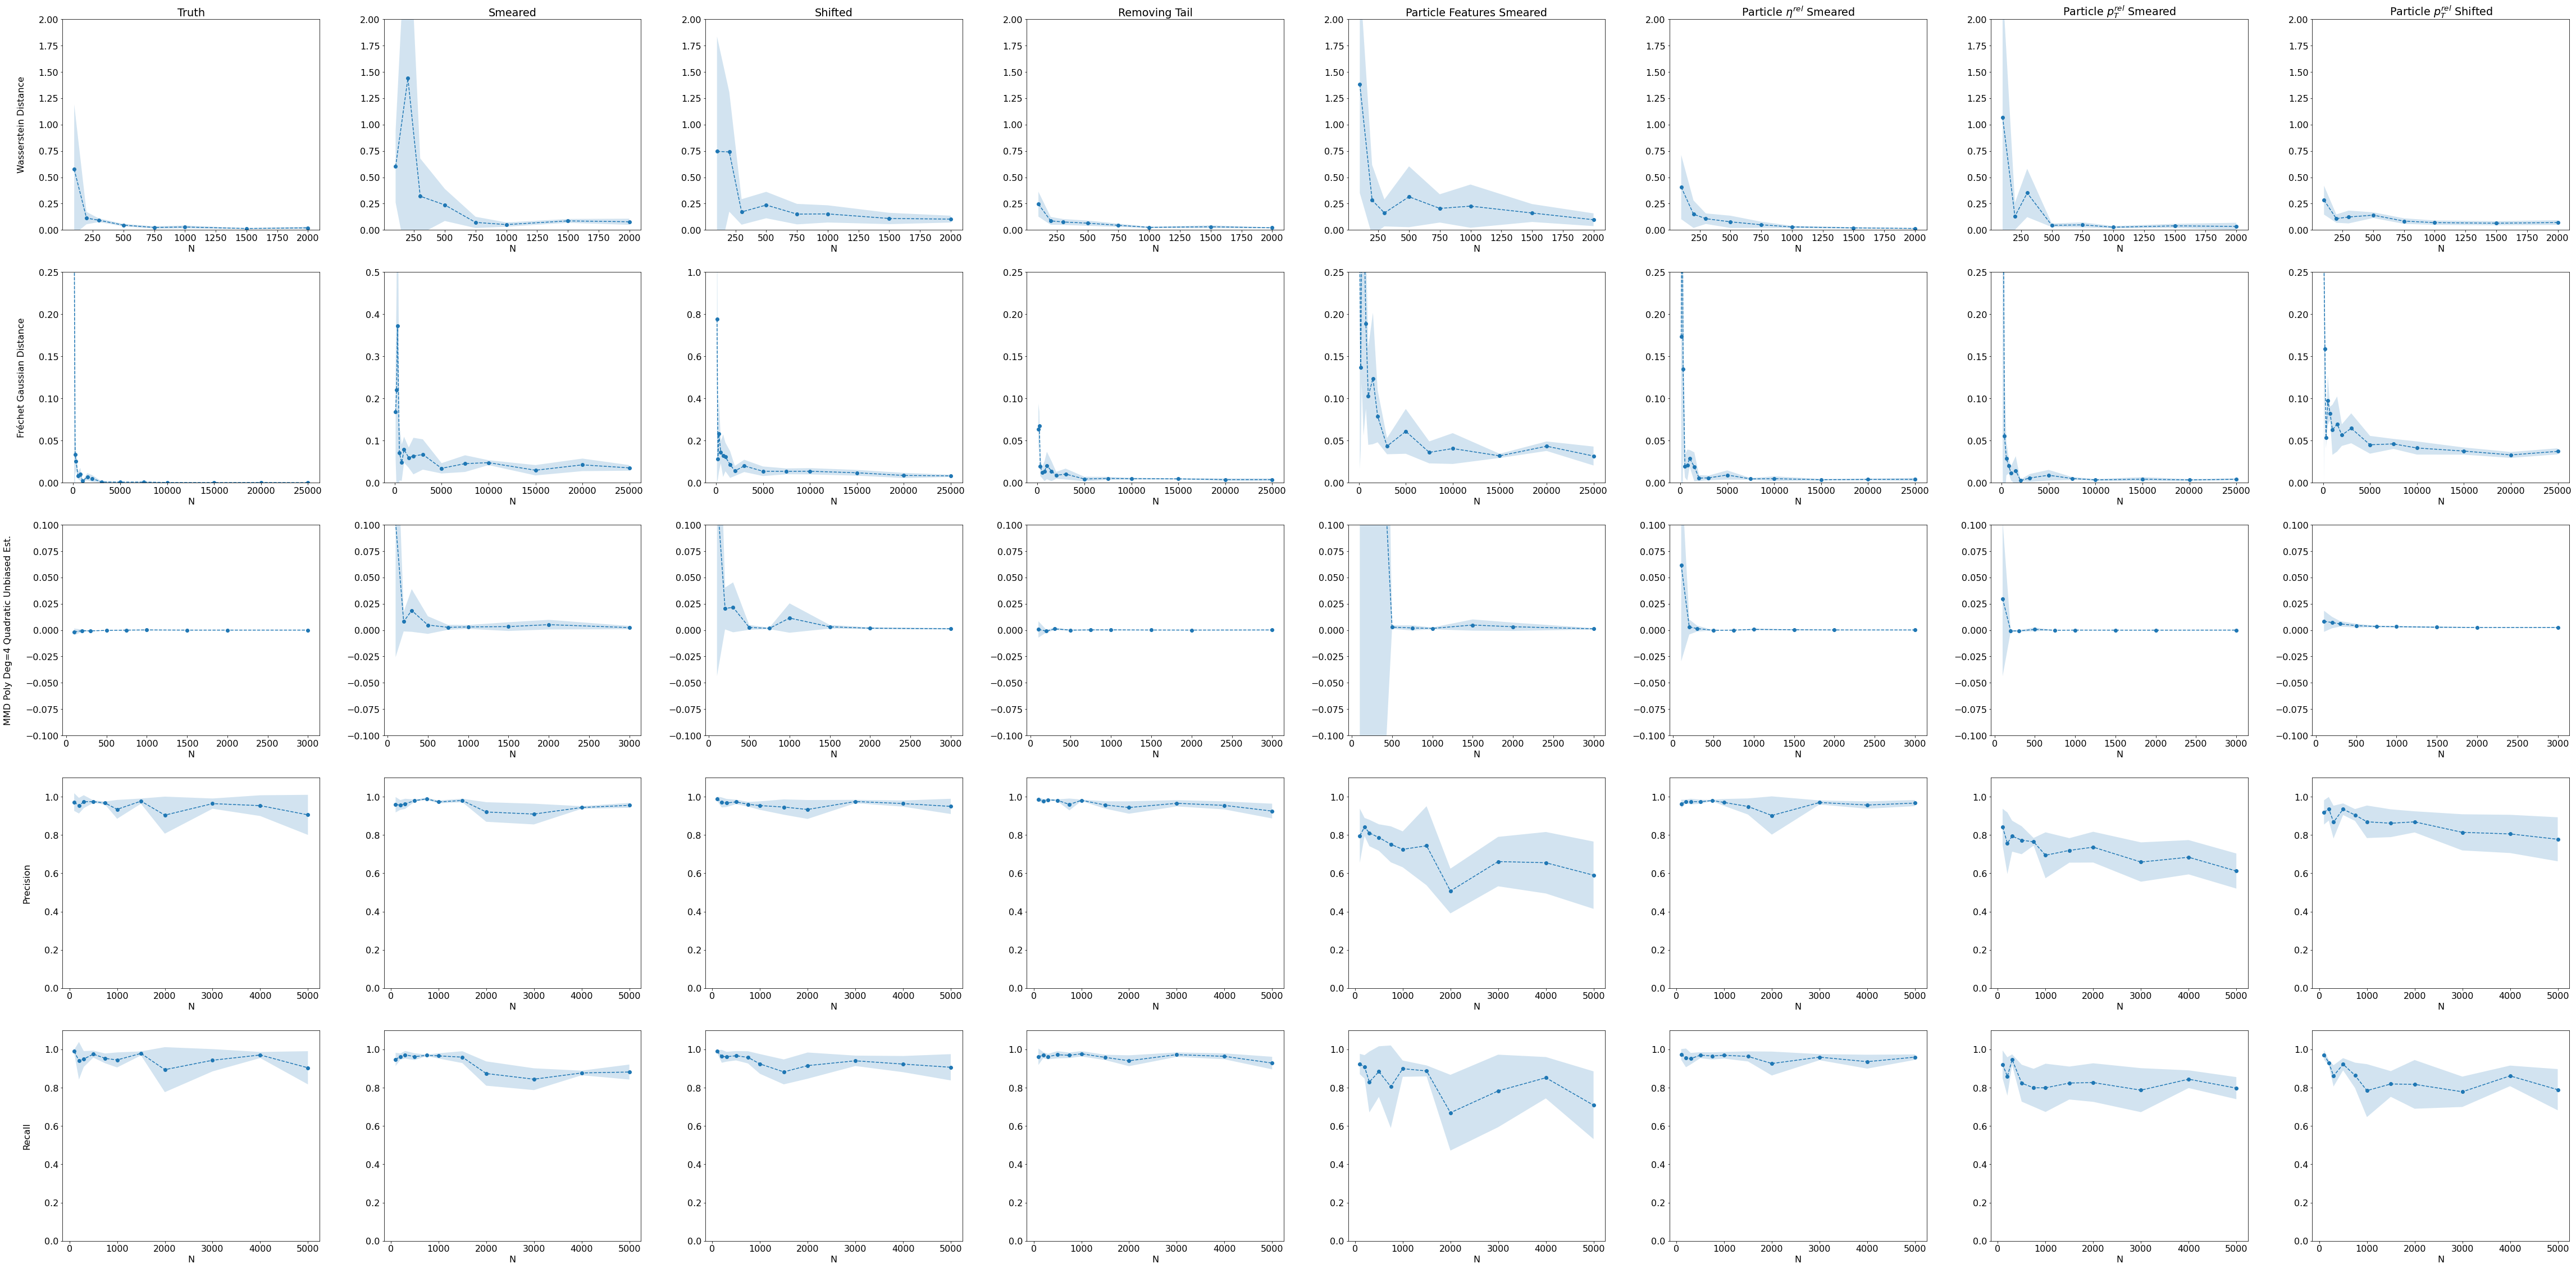

In [70]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2])),
        ("fgd", ([0, 0.25], [0, 0.5], [0, 1], [0, 0.25], [0, 0.25], [0, 0.25], [0, 0.25], [0, 0.25])),
        ("mmdup4", ([-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1])),
        ("precision", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("recall", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey == "prdc" or mkey == "dc" or mkey == "pr":
        continue

    axes[i][0].annotate(
        label,
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        means = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 0])[
            : len(batch_sizes[mkey])
        ]
        stds = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 1])[
            : len(batch_sizes[mkey])
        ]

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[mkey][j])
        axes[i][j].set_xlabel("N")

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, dkey in enumerate(dists | pf_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 0, k])
        stds = np.nan_to_num(measurements_efps[dkey][mkey]["mean_std"][:, 1, k])

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


plt.savefig(f"{plot_dir}/efps_scores.pdf", bbox_inches="tight")


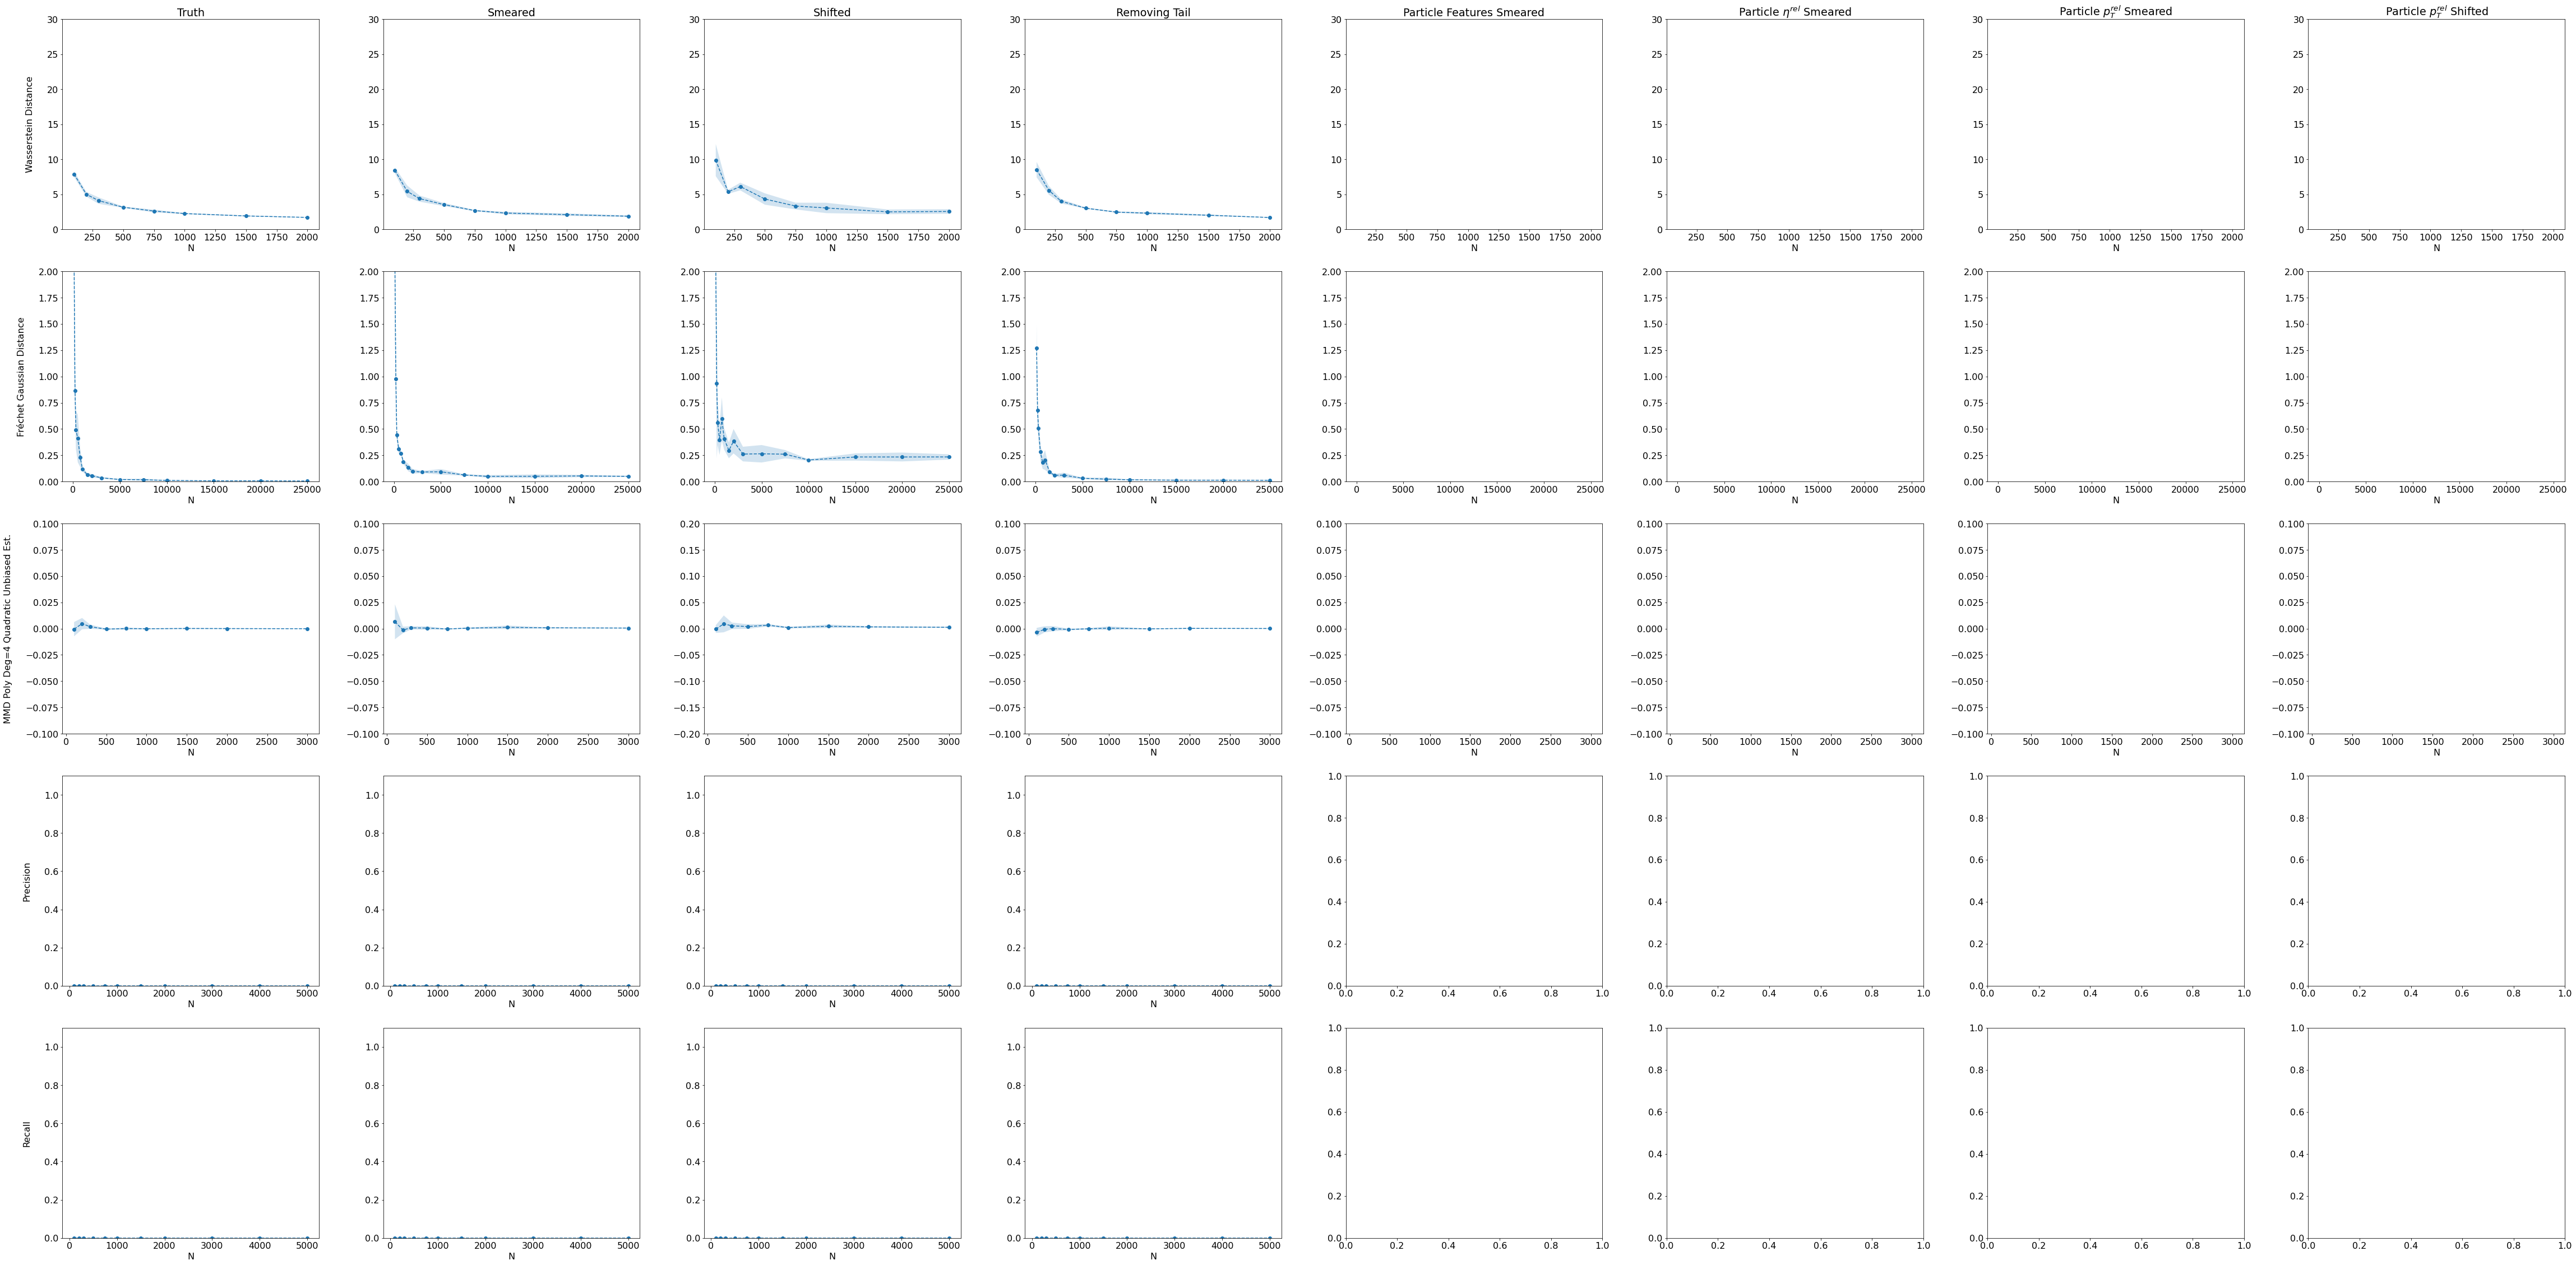

In [78]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 30], [0, 30], [0, 30], [0, 30], [0, 30], [0, 30], [0, 30], [0, 30])),
        ("fgd", ([0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2])),
        ("mmdup4", ([-0.1, 0.1], [-0.1, 0.1], [-0.2, 0.2], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1])),
        ("precision", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("recall", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey == "prdc" or mkey == "dc" or mkey == "pr":
        continue

    axes[i][0].annotate(
        label,
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        means = np.nan_to_num(measurements_acts[dkey][mkey]["mean_std"][:, 0])[
            : len(batch_sizes[mkey])
        ]
        stds = np.nan_to_num(measurements_acts[dkey][mkey]["mean_std"][:, 1])[
            : len(batch_sizes[mkey])
        ]

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[mkey][j])
        axes[i][j].set_xlabel("N")

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        rotation=90,
    )
    for j, dkey in enumerate((dists | pf_dists)):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(
            measurements_acts[dkey][mkey]["mean_std"][:, 0, k][: len(batch_sizes[mkey])]
        )
        stds = np.nan_to_num(
            measurements_acts[dkey][mkey]["mean_std"][:, 1, k][: len(batch_sizes[mkey])]
        )

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


plt.savefig(f"{plot_dir}/acts_scores.pdf", bbox_inches="tight")


In [72]:
rows = []

for mkey, (metric, metric_args, label) in metrics.items():
    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l + " EFP"]

            for dkey, values in measurements_efps.items():
                row.append(
                    f"{values[mkey]['mean_std'][-1][0][i]:.3f} ± {values[mkey]['mean_std'][-1][1][i]:.3f}"
                )

            rows.append(row)
        # continue
    else:
        row = [label + " EFP"]

        for dkey, values in measurements_efps.items():
            row.append(
                f"{values[mkey]['mean_std'][-1][0]:.8f} ± {values[mkey]['mean_std'][-1][1]:.8f}"
            )

        rows.append(row)

# for mkey, (metric, metric_args, label) in metrics.items():
#     if isinstance(label, list):
#         # for i, l in enumerate(label):
#         #     row = [l + " PNet Activations"]

#         #     for dkey, values in measurements_acts.items():
#         #         row.append(
#         #             f"{values[mkey]['mean_std'][-1][0][i]:.3f} ± {values[mkey]['mean_std'][-1][1][i]:.3f}"
#         #         )

#         #     rows.append(row)
#         continue
#     else:
#         row = [label + " PNet Activations"]

#         for dkey, values in measurements_acts.items():
#             row.append(
#                 f"{values[mkey]['mean_std'][-1][0]:.3f} ± {values[mkey]['mean_std'][-1][1]:.3f}"
#             )

#         rows.append(row)

results = pd.DataFrame(
    rows, columns=["Metric"] + list(np.array(list((dists | pf_dists).values()), dtype=object)[:, 1])
)

display(Markdown(results.to_markdown()))


|    | Metric                                     | Truth                   | Smeared                 | Shifted                 | Removing Tail           | Particle Features Smeared   | Particle $\eta^{rel}$ Smeared   | Particle $p_T^{rel}$ Smeared   | Particle $p_T^{rel}$ Shifted   |
|---:|:-------------------------------------------|:------------------------|:------------------------|:------------------------|:------------------------|:----------------------------|:--------------------------------|:-------------------------------|:-------------------------------|
|  0 | Wasserstein Distance EFP                   | 0.01991781 ± 0.01048222 | 0.07765483 ± 0.02909170 | 0.10280542 ± 0.03265306 | 0.02049987 ± 0.00432461 | 0.09693308 ± 0.06041876     | 0.01408649 ± 0.00371466         | 0.03356989 ± 0.03458296        | 0.07011567 ± 0.02192620        |
|  1 | Fréchet Gaussian Distance EFP              | 0.00009275 ± 0.00003298 | 0.03515793 ± 0.00665476 | 0.03249055 ± 0.00557375 | 0.00366874 ± 0.00137769 | 0.03165823 ± 0.01122983     | 0.00394107 ± 0.00173029         | 0.00404441 ± 0.00115684        | 0.03719973 ± 0.00361392        |
|  2 | MMD Poly Deg=4 Quadratic Unbiased Est. EFP | 0.00001436 ± 0.00004863 | 0.00241807 ± 0.00155444 | 0.00131246 ± 0.00061808 | 0.00014815 ± 0.00015404 | 0.00124590 ± 0.00067695     | 0.00014091 ± 0.00011209         | 0.00001894 ± 0.00007982        | 0.00252460 ± 0.00032718        |
|  3 | Precision EFP                              | 0.905 ± 0.105           | 0.955 ± 0.013           | 0.949 ± 0.040           | 0.925 ± 0.039           | 0.590 ± 0.176               | 0.967 ± 0.016                   | 0.612 ± 0.092                  | 0.778 ± 0.115                  |
|  4 | Recall EFP                                 | 0.904 ± 0.087           | 0.882 ± 0.039           | 0.907 ± 0.069           | 0.929 ± 0.033           | 0.709 ± 0.177               | 0.960 ± 0.014                   | 0.798 ± 0.058                  | 0.790 ± 0.108                  |